# Approach 1: Linear regression and classic ML

The purpose of this notebook is to use some simple statistical learning models to predict end of season OBP given early season data. We will start with linear regression models and advance to some slightly more advanced machine learning models. 

## Import modules

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm

# Define colors
phillies_red  = np.divide((232, 24, 40),255)
phillies_blue = np.divide((0, 45, 114),255)

## Load data

In [2]:
# Load data as bd -> short for batting data
bd = pd.read_csv("./data/batting.csv")

In [3]:
# Convert and % str to float
cols = [col for col in bd.columns if '%' in col] + ["MarApr_HR/FB"]
for col in cols:
    bd[col] = bd[col].str.rstrip('%').astype('float') / 100.0

In [4]:
bd.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.361,0.057,0.400,0.226,0.660,0.407,0.811,0.884,0.860,0.406
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.410,0.118,0.412,0.279,0.724,0.448,0.566,0.878,0.757,0.429
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.333,0.000,0.222,0.402,0.745,0.535,0.543,0.854,0.711,0.315
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.405,0.000,0.200,0.273,0.505,0.373,0.939,0.978,0.962,0.353
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.519,0.074,0.296,0.237,0.488,0.337,0.661,0.827,0.757,0.341


## Data exploration

To begin, let's just check out some of the data and see what it looks like. We will start with a few histograms to see data distributions. First we will look at distributions of "getting up to bat" and then we will look at things that help get a player on base (e.g., walks, hits, etc.). We won't yet consider ones that results as a cause of being on base (e.g., SB, R, etc.).

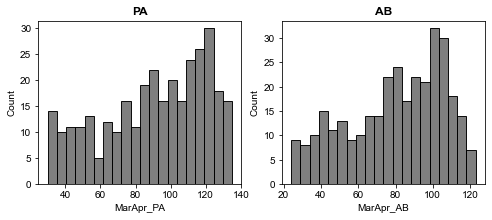

In [5]:
cols_2_show = ["PA","AB"]
# Make figure
fig, allax = plt.subplots(1,2)
# flatax = ax.flatten()
fig.set_size_inches(8,3)
# Show histograms
for cnt, col in enumerate(cols_2_show):
    this_col = "MarApr_" + col 
    sns.histplot(data=bd,x=this_col,ax=allax[cnt],color='k',alpha=0.5,bins=20)
    allax[cnt].set_title(col,fontweight="bold")

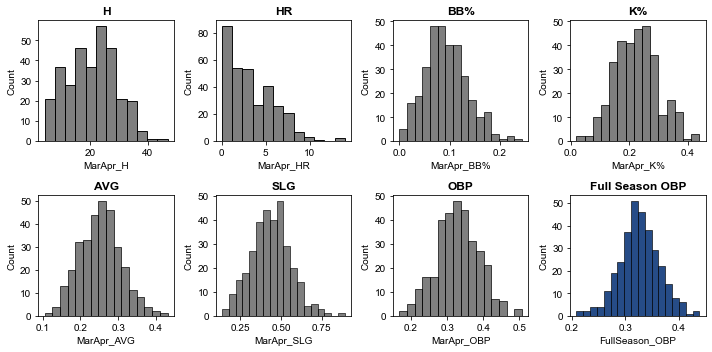

In [6]:
cols_2_show = ["H","HR","BB%","K%","AVG","SLG","OBP"]
# Make figure
fig, allax = plt.subplots(2,4)
allax = allax.flatten()
fig.set_size_inches(10,5)
# Show histograms
for cnt, col in enumerate(cols_2_show):
    this_col = "MarApr_" + col 
    sns.histplot(data=bd,x=this_col,ax=allax[cnt],color='k',alpha=0.5)
    allax[cnt].set_title(col,fontweight="bold")

# Add season OBP
cnt += 1
sns.histplot(data=bd,x="FullSeason_OBP",ax=allax[cnt],color=phillies_blue,alpha=.85)
allax[cnt].set_title("Full Season OBP",fontweight="bold")

plt.tight_layout()



## Correlation between features and season OBP

As a completely naive approach, let's see what happens when we plot each feature against season OBP. 

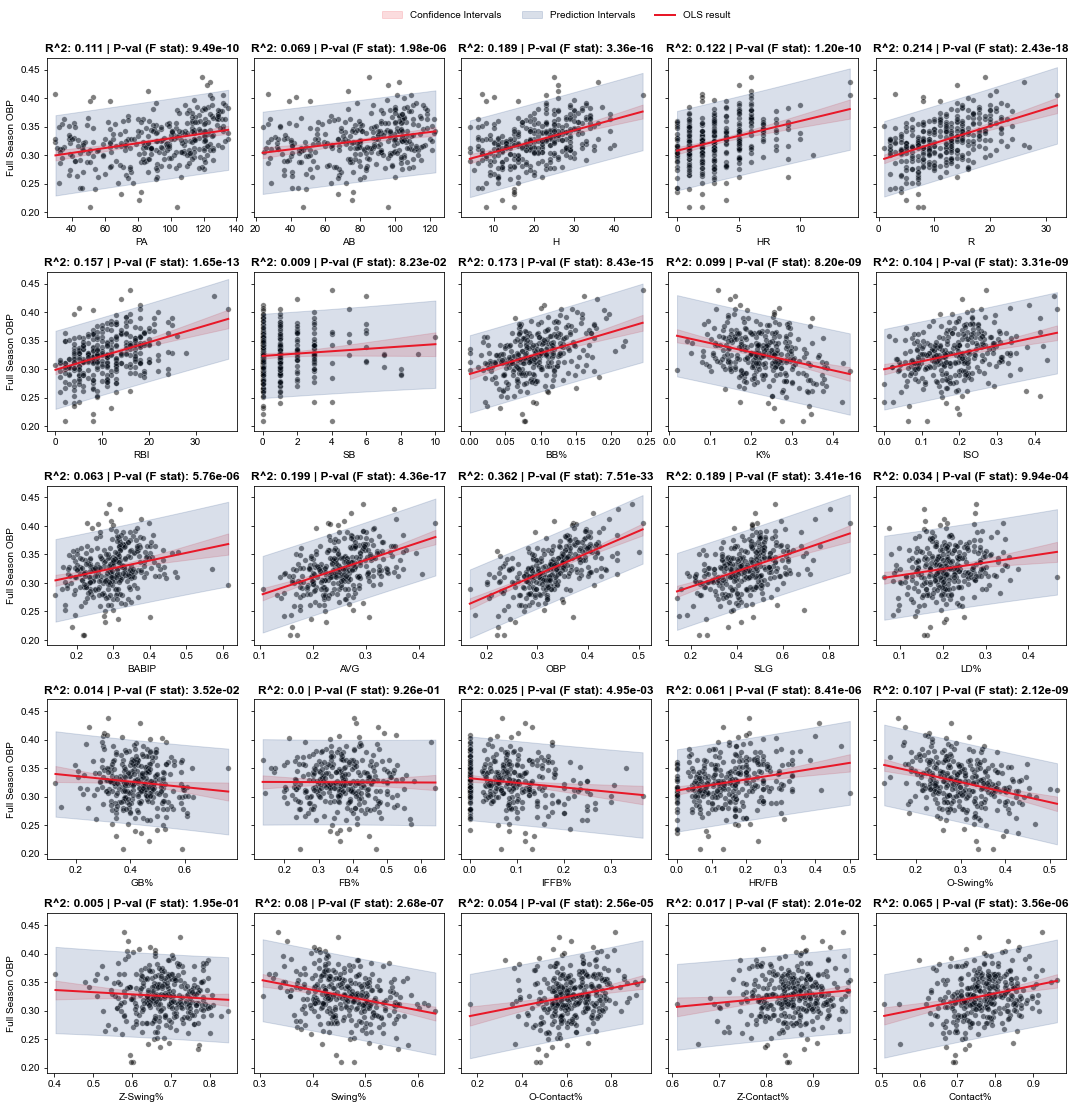

In [7]:
# OLS using statsmodels
def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

# Look at data columns
cols_2_show = [col.removeprefix('MarApr_') for col in bd.columns if 'MarApr_' in col]

# Make figure
fig, allax = plt.subplots(5,5,sharey=True)
allax = allax.flatten()
fig.set_size_inches(15,15)

# Show data
for cnt, col in enumerate(cols_2_show):
    # Plot data
    this_col = 'MarApr_' + col
    sns.scatterplot(data=bd,x=this_col,y="FullSeason_OBP",ax=allax[cnt],color='k',alpha=0.5,s=30)
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")

    # Run regression
    model = run_regression(bd[this_col],bd["FullSeason_OBP"])
    xvals= np.linspace(bd[this_col].min(),bd[this_col].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    allax[cnt].fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    allax[cnt].fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    allax[cnt].plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    allax[cnt].set_title("R^2: {} | P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold")

plt.tight_layout()

allax[2].legend(loc=9,ncol=3,bbox_to_anchor=(0.5,1.35),frameon=False)




It is pretty interesting to see that quite a few have a signficant F-statistic for the regression. There are a few with a *fair* R^2 value, such as PA, R, OBP, etc. I think it is interesting that some of these predictors are a cause of getting on base while others are a result of being on base.

## Naive prediction using linear models

### Ordinary least squares (OLS)

Now lets see what it looks like to predict the full season OBP using each feature individually. We will split the data into a train and test set. Since we are not optimizing any parameters, such as a regularization parameter or a more complicated model (e.g., neural network), we will just evaluate the model on our test set and won't peform a k-fold validation.

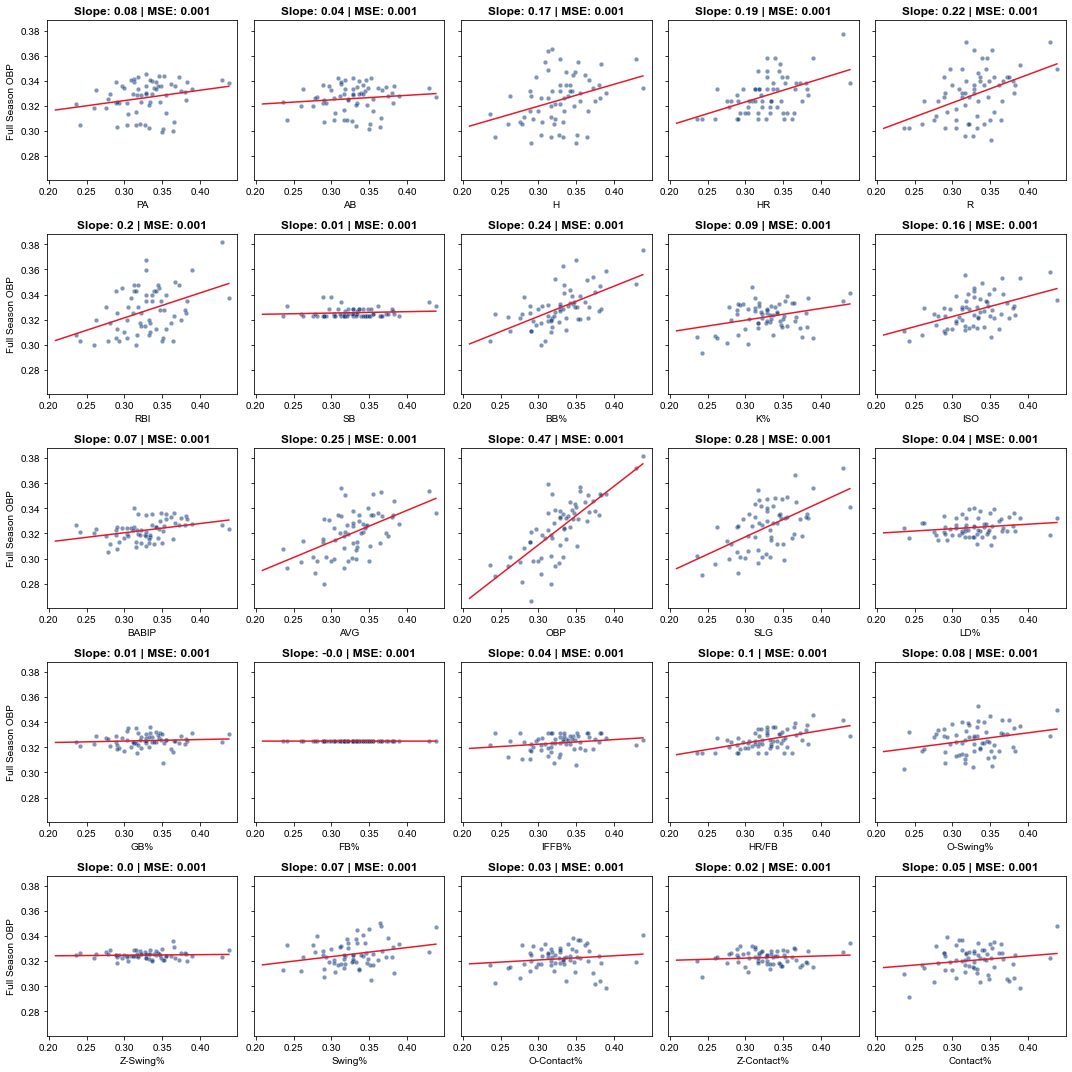

In [34]:
from sklearn.model_selection import train_test_split

# Standardize columns to make the comparison of predictors better.
bd_centered = bd.loc[:,[col for col in bd.columns if 'MarApr_' in col]].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
bd_centered["FullSeason_OBP"] = bd["FullSeason_OBP"]

# Make figure
fig, allax = plt.subplots(5,5,sharey=True)
allax = allax.flatten()
fig.set_size_inches(15,15)

# Make xdata
xout = np.linspace(bd_centered["FullSeason_OBP"].min(),bd_centered["FullSeason_OBP"].max(),100)
xout2 = sm.add_constant(xout)

# Make variables for storing results
aic, bic, mse, slope, LL = [], [], [], [], []
# For each column in the data
for cnt, col in enumerate(cols_2_show):
    
    # Split train/test data
    this_col = 'MarApr_' + col
    x_train, x_test, y_train, y_test = train_test_split(bd_centered[this_col],bd_centered["FullSeason_OBP"],test_size=0.20, random_state=4)
  
    # Run regression
    model = run_regression(x_train,y_train)
    xvals= sm.add_constant(x_test)
    y_predict = model.predict(xvals)
    mse.append(np.mean(np.square(y_predict - y_test)))
    aic.append(model.aic)
    bic.append(model.bic)
    LL.append(model.llf)
    
    # Plot
    sns.scatterplot(x=y_test,y=y_predict,ax=allax[cnt],color=phillies_blue,alpha=0.5,s=20)
    out = run_regression(y_test,y_predict)
    allax[cnt].plot(xout,out.predict(xout2),color=phillies_red)
    allax[cnt].set_title("Slope: {} | MSE: {}".format(round(out.params[1],2),round(np.mean(np.square(y_predict - y_test)),3)),fontweight="bold")
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")
    slope.append(out.params[1])

plt.tight_layout()


These results demonstrate that while some of these individual features were correlated with the full season OBP, the posess very little predictive power when it comes to predicting based on a single feature at a time. The figures above show the relationship between the actual OBP and the predicted value, so ideally, we are looking for a slope close to 1.

In [35]:
ols_df = pd.DataFrame({"Feature":cols_2_show, "MSE": mse, "Slope": slope, "AIC": aic, "BIC": bic, "Log-likelihod": LL}).set_index("Feature").sort_values(by="MSE")
ols_df

,MSE,Slope,AIC,BIC,Log-likelihod
Feature,,,,,
OBP,0.000659,0.467994,-1047.116575,-1040.026220,525.558287
BB%,0.000990,0.241070,-987.850671,-980.760316,495.925336
SLG,0.001011,0.278347,-995.682455,-988.592100,499.841227
AVG,0.001096,0.250394,-1003.879891,-996.789536,503.939946
HR,0.001135,0.186466,-977.578825,-970.488470,490.789412
ISO,0.001154,0.161508,-971.814692,-964.724337,487.907346
R,0.001190,0.224576,-1015.687132,-1008.596777,509.843566
RBI,0.001212,0.198323,-994.658598,-987.568243,499.329299
HR/FB,0.001226,0.100894,-958.186173,-951.095818,481.093086


This table summarizes what we see above. Based on the features we have (and a linear regression model), current on base percentage, walk rate, slugging percentage, batting average, and home runs are the top five predictors of future OBP based on the mean square error. Interestingly, the model ranking changes a bit if we consider AIC, BIC, or log-likelihood for comparison, but current OBP seems to be the most reliable individual predictor for all metrics. Notice we are looking at the value named "slope". This is the slope of the line fitted to the predicted results and true results. Ideally, this is close to 1 if the values are extremely well predicted. This is not a standard, or even perhaps valid, way to evaluate models but it does provide some visual intuition about the difference between the predicted results and the true values. 

### Robust regression using robust linear models (RLM)

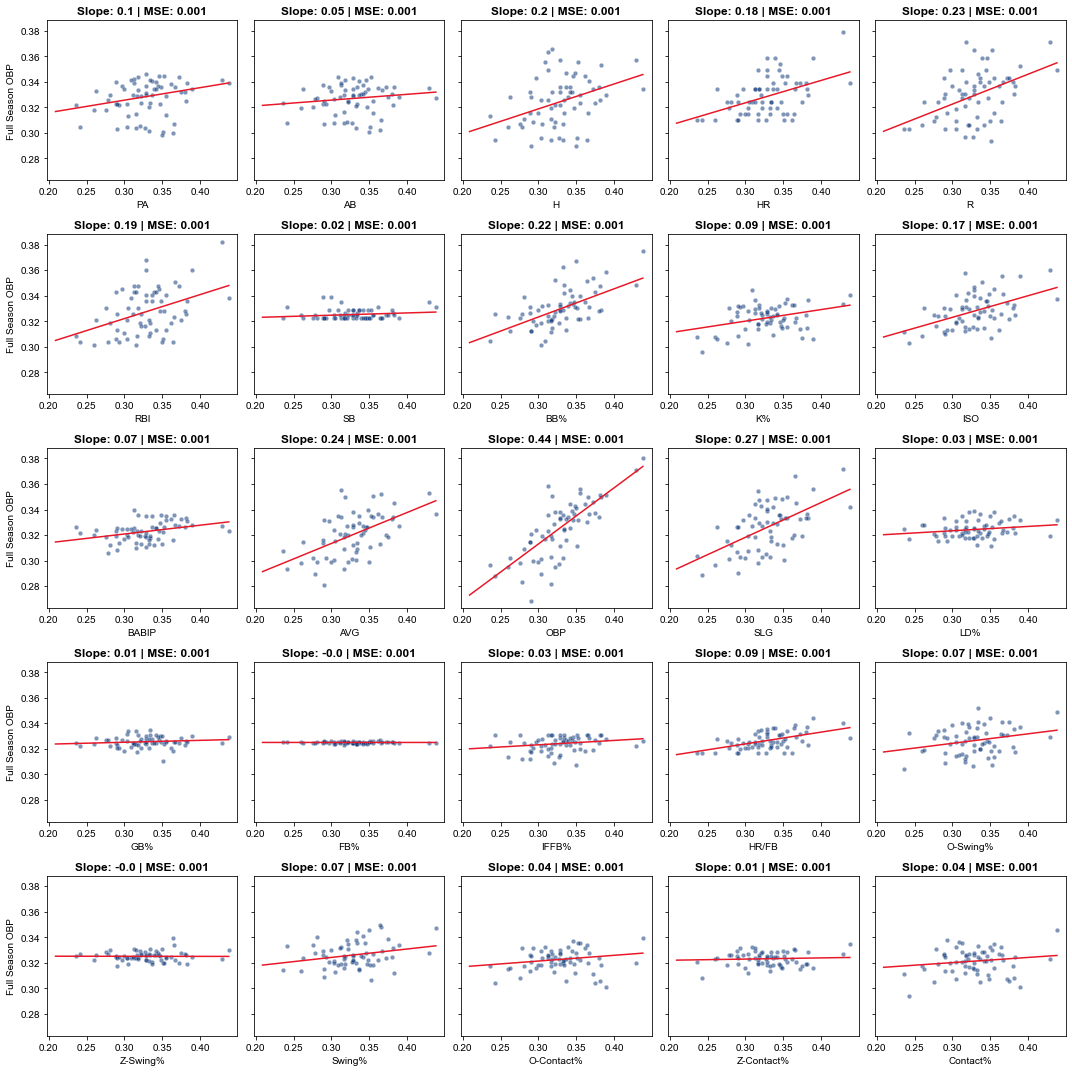

In [32]:
# OLS using statsmodels
def robust_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    rlm = sm.RLM(yy,X)
    rlm_result = rlm.fit()
    return rlm_result

# Make figure
fig, allax = plt.subplots(5,5,sharey=True)
allax = allax.flatten()
fig.set_size_inches(15,15)

# Make xdata
xout = np.linspace(bd_centered["FullSeason_OBP"].min(),bd_centered["FullSeason_OBP"].max(),100)
xout2 = sm.add_constant(xout)

# Make variables for storing results
mse, slope= [], []

# For each column in the data
for cnt, col in enumerate(cols_2_show):
    
    # Split train/test data
    this_col = 'MarApr_' + col
    x_train, x_test, y_train, y_test = train_test_split(bd_centered[this_col],bd_centered["FullSeason_OBP"],test_size=0.20, random_state=4)
  
    # Run regression
    model = robust_regression(x_train,y_train)
    xvals= sm.add_constant(x_test)
    y_predict = model.predict(xvals)
    mse.append(np.mean(np.square(y_predict - y_test)))
    
    # Plot
    sns.scatterplot(x=y_test,y=y_predict,ax=allax[cnt],color=phillies_blue,alpha=0.5,s=20)
    out = robust_regression(y_test,y_predict)
    allax[cnt].plot(xout,out.predict(xout2),color=phillies_red)
    allax[cnt].set_title("Slope: {} | MSE: {}".format(round(out.params[1],2),round(np.mean(np.square(y_predict - y_test)),3)),fontweight="bold")
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")
    slope.append(out.params[1])
plt.tight_layout()


Lets compare the MSE and slope (line fit to predicted vs true values of season OBP) for ordinary and robust regression.

In [36]:
rlm_df = pd.DataFrame({"mse_rlm": mse, "mse_ols": ols_df.loc[:,"MSE"], "slope_rlm": slope, "slope_ols": ols_df.loc[:,"Slope"]})
rlm_df

,mse_rlm,mse_ols,slope_rlm,slope_ols
Feature,,,,
OBP,0.001397,0.000659,0.082546,0.467994
BB%,0.001484,0.000990,0.036076,0.241070
SLG,0.001336,0.001011,0.174531,0.278347
AVG,0.001135,0.001096,0.186466,0.250394
HR,0.001190,0.001135,0.224576,0.186466
ISO,0.001212,0.001154,0.198323,0.161508
R,0.001455,0.001190,0.010908,0.224576
RBI,0.000990,0.001212,0.241070,0.198323
HR/FB,0.001343,0.001226,0.093489,0.100894


## Advanced regression using off-the-shelf models

### Lets start with a random forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

def MSE(x,y):
    return np.mean(np.square(x-y))
    
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(bd_centered.loc[:,[col for col in bd.columns if 'MarApr_' in col]],bd_centered.loc[:,"FullSeason_OBP"],test_size=0.20, random_state=5)

# Train random forest
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(x_train, y_train)  

# Predict
rf_results = rf.predict(x_test)
print("MSE: {}".format(MSE(rf_results,y_test)))


MSE: 0.0006919836052704109


Let's quickly look at which features contribute to the results. We will use shapley values for our feature analysis.

/Users/justinbrantley/miniconda3/envs/phillies-project-ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


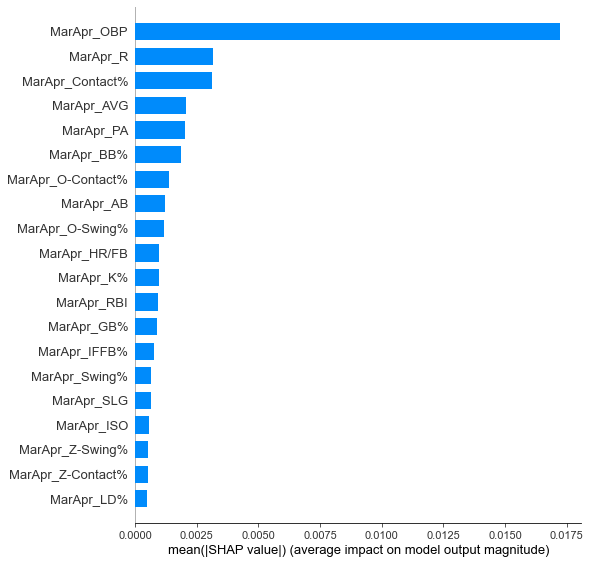

In [11]:
import shap

# compute SHAP values
shap_values = shap.TreeExplainer(rf).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

Again, we see that full season OBP is best predicted by current OBP. Now lets try with a different model.

### Support Vector Regression

We will just try all available kernels with default params to see how the system learns between each type.

In [20]:
from sklearn.svm import SVR

kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    # Use defined kernel with default params
    regressor = SVR(kernel = kernel)
    regressor.fit(x_train, y_train)

    # Test on hold out data
    svr_results = regressor.predict(x_test)
    print("MSE: {} for {} kernel".format(MSE(svr_results,y_test), kernel))

MSE: 0.0008742347010641758 for linear kernel
MSE: 0.0010789303043768983 for poly kernel
MSE: 0.00091893197293671 for rbf kernel
MSE: 0.0007916071495859964 for sigmoid kernel


I am sure with some optimization we could improve the results slightly, but it is interesting to see that these results are not that different from before. 

### XGBoost

Finally, let's try XGBoost and we will even add kfold x-validation just to see if things change. Again, the kfold here is just to see average performance over the folds. We will still train a final model on the full training set and evaluate on the test set. 

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from xgboost import XGBRegressor

# Create an xgboost regression model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)

In [13]:
print("MSE: {}".format(scores.mean()))

MSE: 0.0010475411516556801


Interestingly, this is higher than our random forest model, some of the SVR models, and our linear regression using only single features. Lets try training the full model and seeing the performance. 

In [14]:
model = XGBRegressor().fit(x_train.to_numpy(),y_train.to_numpy())
xgb_results = model.predict(x_test)

# Check MSE
print("MSE: {}".format(MSE(xgb_results,y_test)))

MSE: 0.0009280275911824446


## Add new data

Notice that the dates are limited to the months of March and April.

In [ ]:
import pybaseball
from pybaseball import statcast

# Get data
data = statcast(start_dt='2019-03-01', end_dt='2019-04-30')

In [94]:
# Clean up
data['launch_angle'] = data['launch_angle'].astype(float)
data.dropna(subset=["launch_angle"],inplace=True)

data['launch_speed'] = data['launch_speed'].astype(float)
data.dropna(subset=["launch_speed"],inplace=True)

# Sample
data.loc[data.home_team.isin(["PHI"]),:].sample(10)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3323,FF,2019-03-31,93.2,-1.93,5.49,"Neris, Héctor",459964,593576,field_out,hit_into_play,...,5,1,5,1,5,Standard,Standard,215,0.004,-0.231
1227,FF,2019-04-16,92.0,-2.18,5.66,"Gagnon, Drew",592663,543193,home_run,hit_into_play,...,2,2,11,11,2,Standard,Standard,229,0.004,1.0
2856,FF,2019-03-28,94.9,-1.83,5.48,"Neris, Héctor",459964,593576,None,foul,...,6,1,6,1,6,Standard,Standard,203,0.0,-0.057
2580,KC,2019-03-30,77.8,-2.84,5.84,"Pivetta, Nick",645277,601713,None,foul,...,0,1,0,1,0,Standard,Standard,48,0.0,-0.03
167,FF,2019-04-25,91.9,-1.82,4.86,"Nola, Aaron",605119,605400,None,foul,...,1,1,1,1,1,Standard,Standard,222,0.0,0.0
2075,SI,2019-04-15,87.2,1.87,5.67,"Álvarez, José",605204,501625,field_out,hit_into_play,...,5,5,5,5,5,Standard,Standard,125,0.046,-0.338
1242,FS,2019-04-25,87.7,-2.02,5.46,"Neris, Héctor",435522,593576,double,hit_into_play,...,1,1,1,1,1,Infield shift,Standard,229,-0.072,0.245
2012,FS,2019-04-25,85.4,-2.06,5.63,"Neris, Héctor",621446,593576,sac_bunt,hit_into_play,...,1,1,1,1,1,Strategic,Standard,264,0.02,-0.101
1812,SL,2019-04-07,88.1,-2.94,5.66,"Eflin, Zach",621439,621107,field_out,hit_into_play,...,0,1,0,1,0,Standard,Standard,156,0.026,-0.322
455,SL,2019-04-27,89.0,-3.28,5.86,"Arrieta, Jake",594011,453562,field_out,hit_into_play,...,4,1,4,1,4,Standard,Standard,150,0.008,-0.099


Get player info to match fangraphs and statcast entry (key_mlbam)

In [ ]:
_players = pybaseball.playerid_reverse_lookup(bd.playerid.tolist(),key_type='fangraphs')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

Add MLB ID to dataframe to match against statcast data.

In [330]:
def add_mlb_id(row,_players):
    row["key_mlbam"] = _players.loc[_players.key_fangraphs.isin([row.playerid]),"key_mlbam"].item()
    return row

# Load data as bd -> short for batting data
bd = pd.read_csv("./data/batting.csv")

# Convert and % str to float
cols = [col for col in bd.columns if '%' in col] + ["MarApr_HR/FB"]
for col in cols:
    bd[col] = bd[col].str.rstrip('%').astype('float') / 100.0
    
bd = bd.apply(lambda row: add_mlb_id(row,_players),axis=1)
bd.head()



,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP,key_mlbam
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.057,0.400,0.226,0.660,0.407,0.811,0.884,0.860,0.406,641355
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.118,0.412,0.279,0.724,0.448,0.566,0.878,0.757,0.429,592885
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.000,0.222,0.402,0.745,0.535,0.543,0.854,0.711,0.315,664068
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.000,0.200,0.273,0.505,0.373,0.939,0.978,0.962,0.353,519299
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.074,0.296,0.237,0.488,0.337,0.661,0.827,0.757,0.341,596129


Get statcast data for batters in provided dataframe. 

In [331]:
def add_statcast_data(row,group_data,cols_2_add=[],events=[]):

    # # Get value counts as % of AB
    event_counts =  group_data.events.value_counts()
    for name in events:
        if name in event_counts.index.tolist():
            val = event_counts[name]/row["MarApr_AB"]
        else:
            val = 0
        row["MarApr_" + name] = val#event_counts[name]/row["MarApr_AB"] if name in event_counts.index.tolist() else 0

    # Get data for specific columns and compute average
    filt_data = group_data.loc[:,[col for col in cols_2_add if col != "events"]].mean()

    # Return concatenated data frame
    return pd.concat([row,filt_data.add_prefix("MarApr_")])

# Define columns to add to data
cols_2_add = ["launch_speed","launch_angle","events","pfx_z","pfx_x","release_speed","release_spin_rate"]
events     = ["single","double","triple","field_out","double_play"]

# Group statcast data by batter
grouped_data = data.loc[data.batter.isin(bd.key_mlbam.tolist()),:].groupby(by="batter")

# Apply function to each row
bd = bd.apply(lambda row: add_statcast_data(row,grouped_data.get_group(row.key_mlbam),cols_2_add=cols_2_add,events=events),axis=1)
bd.head()


,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_double,MarApr_triple,MarApr_field_out,MarApr_double_play,MarApr_launch_speed,MarApr_launch_angle,MarApr_pfx_z,MarApr_pfx_x,MarApr_release_speed,MarApr_release_spin_rate
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.055046,0.009174,0.385321,0.018349,87.235032,18.292994,0.810637,-0.219299,88.812102,2188.322581
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.039216,0.000000,0.441176,0.000000,89.436364,14.803030,0.860530,-0.215455,89.756818,2201.229008
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.125000,0.000000,0.375000,0.000000,82.207317,13.707317,0.706829,-0.071463,89.407317,2283.024390
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.093023,0.000000,0.465116,0.000000,83.076271,21.881356,0.669322,-0.305763,88.010169,2255.440678
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.084507,0.000000,0.422535,0.000000,86.067033,23.241758,0.687802,-0.388022,89.013187,2195.700000


### Correlation between features and season OBP

Let's do the same thing as earlier and check the correlation between the new values and the full season OBP.

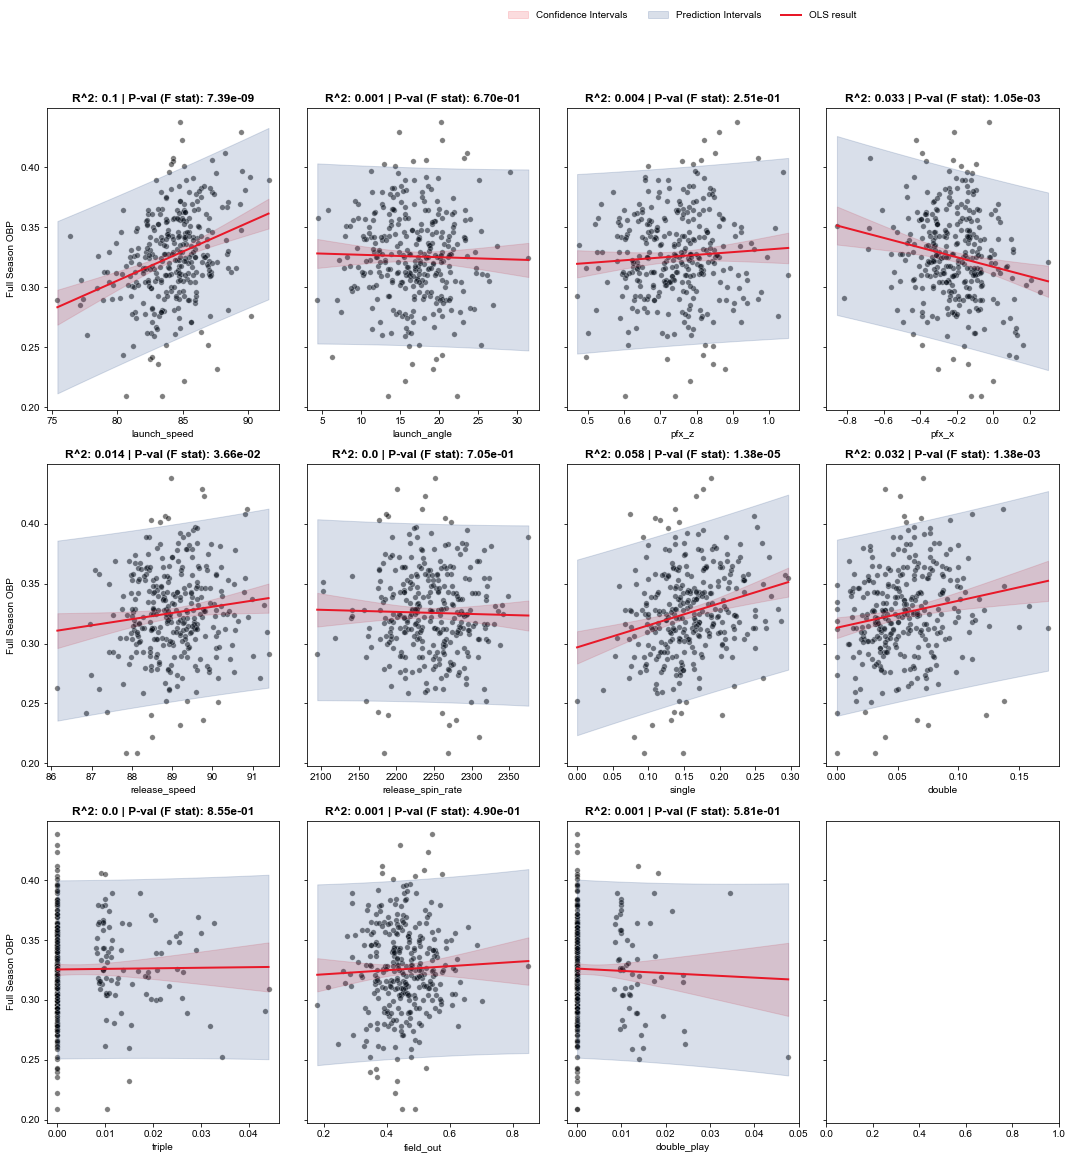

In [332]:
# OLS using statsmodels
def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

# Make figure
fig, allax = plt.subplots(3,4,sharey=True)
allax = allax.flatten()
fig.set_size_inches(15,15)

# Show data
for cnt, col in enumerate([col for col in cols_2_add if col != "events"] + events):
    # Plot data
    this_col = 'MarApr_' + col
    sns.scatterplot(data=bd,x=this_col,y="FullSeason_OBP",ax=allax[cnt],color='k',alpha=0.5,s=30)
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")

    # Run regression
    model = run_regression(bd[this_col],bd["FullSeason_OBP"])
    xvals= np.linspace(bd[this_col].min(),bd[this_col].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    allax[cnt].fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    allax[cnt].fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    allax[cnt].plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    allax[cnt].set_title("R^2: {} | P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold")

plt.tight_layout()

allax[2].legend(loc=9,ncol=3,bbox_to_anchor=(0.5,1.35),frameon=False)



Strangely enough, the new values do not seem to show a strong correlation with full season OBP. It might have been a stretch with values like `pfx_z` and `pfx_x`, which provide the plate location of the pitch. Over many pitches in the two-month period, it is quite possible that these average out completely. Additionally, values like percentage of single, double, etc. are essentially already within the data from our slugging percentage calculation. 

On the other hand, given a particular player's tendencies, I expected launch angle and speed to show a higher correlation than. Nonetheless, we should see if these impact the predictive power. We will just revist our random forest since this had the lowest MSE, even if only by a thousandth at most. 

In [333]:
# Standardize columns to make the comparison of predictors better.
bd_centered = bd.loc[:,[col for col in bd.columns if 'MarApr_' in col]].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
bd_centered["FullSeason_OBP"] = bd["FullSeason_OBP"]
   
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(bd_centered.loc[:,[col for col in bd.columns if 'MarApr_' in col]],bd_centered.loc[:,"FullSeason_OBP"],test_size=0.20, random_state=5)

# Train random forest
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(x_train, y_train)  

# Predict
rf_results = rf.predict(x_test)
print("MSE: {}".format(MSE(rf_results,y_test)))


MSE: 0.0007019205615848705


Basically exactly the same...

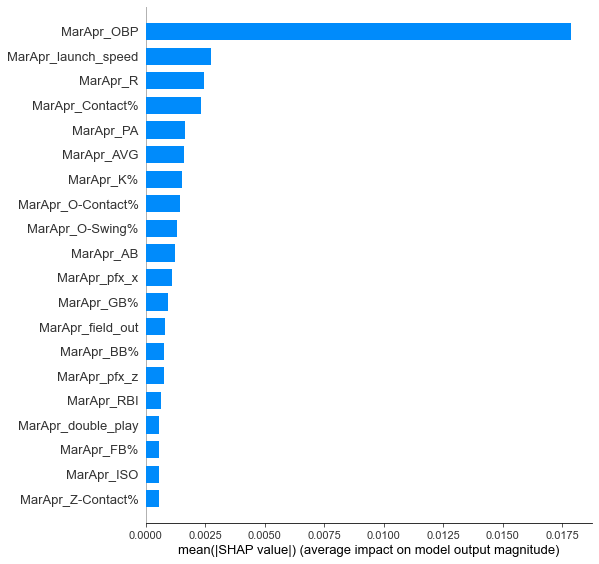

In [334]:
# compute SHAP values
shap_values = shap.TreeExplainer(rf).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

And again, we see current OBP rise to the top of feature importance. We do see that exit velocity has appeared as the second feature, but clearly the majority of the predictive power lies in the current OBP. 

### What happens if we use dimensionality reduction?

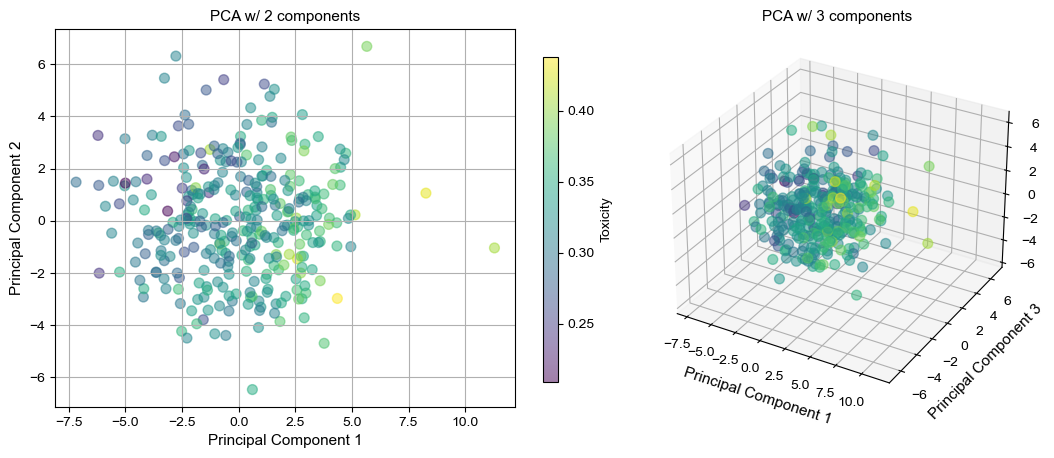

In [335]:
# function taken from my github here: https://github.com/jabrantley/Deep-Learning/blob/main/1_2layerNN_LinearRegression.ipynb

from sklearn import decomposition, linear_model

def pca_plots(X,y):
  # Visualize principal components of data: use two components
  pca_2 = decomposition.PCA(n_components=2)
  pca_2.fit(X)
  X_pca_2 = pca_2.transform(X)

  # Visualize principal components of data: use three components
  pca_3 = decomposition.PCA(n_components=3)
  pca_3.fit(X)
  X_pca_3 = pca_3.transform(X)

  # Colors
  cmap = plt.get_cmap("viridis")
  norm = plt.Normalize(y.min(), y.max())

  # Plot first two PCs
  fig = plt.figure(figsize=(15,5),dpi=100,facecolor='w',edgecolor='k')
  ax1 = fig.add_subplot(1,2,1)
  ax1.set_xlabel('Principal Component 1', fontsize = 11)
  ax1.set_ylabel('Principal Component 2', fontsize = 11)
  ax1.set_title('PCA w/ 2 components', fontsize = 11)
  out = ax1.scatter(X_pca_2[:,0], X_pca_2[:,1], c=y, s = 50,alpha=0.5)
  ax1.grid()

  # Plot first three PCs
  ax2 = fig.add_subplot(1,2,2,projection='3d')
  ax2.set_xlabel('Principal Component 1', fontsize = 11)
  ax2.set_ylabel('Principal Component 2', fontsize = 11)
  ax2.set_ylabel('Principal Component 3', fontsize = 11)
  ax2.set_title('PCA w/ 3 components', fontsize = 11)
  ax2.scatter3D(X_pca_3[:,0], X_pca_3[:,1], X_pca_3[:,2], c=y, s = 50,alpha=0.5)

  # Add colorbar
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.45, 0.175, 0.01, 0.65])
  cbar = fig.colorbar(out, cax=cbar_ax)
  cbar.ax.set_ylabel('OBP')

  plt.show()

pca_plots(bd_centered.loc[:,[col for col in bd.columns if 'MarApr_' in col]],bd_centered.loc[:,"FullSeason_OBP"])

In [339]:
# Fit pca using 2 dimensions
pca = decomposition.PCA(n_components=2)
pca.fit(x_train)

# Train random forest
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(pca.transform(x_train), y_train)  

# Predict
rf_results = rf.predict(pca.transform(x_test))
print("MSE: {}".format(MSE(rf_results,y_test)))

MSE: 0.0007842027093345009


In [340]:
# Save dataframe
bd.to_pickle("./data/batting_data_postML.pkl")